In [6]:

import torch
import argparse
from pathlib import Path
import numpy as np
from src.model_utils import build_model
import src.datasets as datasets
import src.evaluation as evaluation
from src.torch_utils import torch2numpy
from reevaluate import get_test_dataset
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
def get_quantile_forecast(pred, quantile, axis=0):
    # shape is [num_samples, num_series, prediction_length]
    # return the quantile of the samples for each series
    return np.quantile(pred, quantile, axis=axis)


In [2]:
ckpt_file = "./Checkpoints/bouncing_ball.pt"
ckpt = torch.load(ckpt_file, map_location="cpu")

config = ckpt["config"]
model = build_model(config=config)
model.load_state_dict(ckpt["model"])

test_dataset = get_test_dataset(config)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80)
extra_args = dict()
extra_args = {"dur_temperature": 1.0}
device = 'cpu'

In [443]:
def autoregressive_pred(ckpt_file, batch_size=80):

    ckpt = torch.load(ckpt_file, map_location="cpu")

    config = ckpt["config"]
    model = build_model(config=config)
    model.load_state_dict(ckpt["model"])

    test_dataset = get_test_dataset(config)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    #do predictions autoregressively. 
    context_length = config['context_length']
    prediction_length = config['prediction_length']
    ground_truth = []
    all_lb = []
    all_ub = []
    all_mean = []
    # calculate coverage and width of prediction intervals
    for test_batch, test_label in test_loader:
        true = test_batch[:, -prediction_length:]
        autoregressive_lb = []
        autoregressive_ub = []
        autoregressive_mean = []
        for t in tqdm(range(prediction_length)):
            pred = model.predict(test_batch[:,t:t+context_length], num_samples=100, pred_one_step=True)
            pred_y = pred['rec_n_forecast'][:,:,-1]

            mean = get_quantile_forecast(pred_y, 0.5)
            lb = get_quantile_forecast(pred_y, 0.1)
            ub = get_quantile_forecast(pred_y, 0.9) 

            autoregressive_lb.append(lb)
            autoregressive_ub.append(ub)
            autoregressive_mean.append(mean)

        ground_truth.append(true)
        all_lb.append(np.concatenate(autoregressive_lb, 1))
        all_ub.append(np.concatenate(autoregressive_ub, 1))
        all_mean.append(np.concatenate(autoregressive_mean, 1))
    
    ground_truth = np.concatenate(ground_truth, 0).squeeze()
    all_lb = np.concatenate(all_lb, 0)
    all_ub = np.concatenate(all_ub, 0)
    all_mean = np.concatenate(all_mean, 0)

    return ground_truth, all_mean, all_lb, all_ub

def autoregressive_get_truth(ckpt_file):
    ckpt = torch.load(ckpt_file, map_location="cpu")

    config = ckpt["config"]
    model = build_model(config=config)
    model.load_state_dict(ckpt["model"])
    prediction_length = config['prediction_length']

    test_dataset = get_test_dataset(config)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80)
    all_truth = []
    for test_batch, test_label in test_loader:
        true = test_batch[:, -prediction_length:]
        all_truth.append(true)
    all_truth = np.concatenate(all_truth, 0)
    return all_truth


def autoregressive_get_traj(ckpt_file):
    ckpt = torch.load(ckpt_file, map_location="cpu")

    config = ckpt["config"]
    model = build_model(config=config)
    model.load_state_dict(ckpt["model"])
    prediction_length = config['prediction_length']

    test_dataset = get_test_dataset(config)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80)
    all_truth = []
    for test_batch, test_label in test_loader:
        true = test_batch
        all_truth.append(true)
    all_truth = np.concatenate(all_truth, 0)
    return all_truth

In [22]:
ckpt_bb = "./Checkpoints/bouncing_ball.pt"
ckpt_bbnoisy = "./Checkpoints/bb_noisy.pt"

In [23]:
ground_truth, all_mean, all_lb, all_ub = autoregressive_pred(ckpt_bb)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


In [29]:

ground_truth = np.concatenate(ground_truth, 0)
all_lb = np.concatenate(all_lb, 0)
all_ub = np.concatenate(all_ub, 0)
all_mean = np.concatenate(all_mean, 0)


In [48]:
ground_truth = autoregressive_get_truth(ckpt_bb).squeeze()

In [49]:
ground_truth.shape

(1000, 50)

In [47]:
all_lb.shape

(1000, 50)

In [52]:

# coverage
coverage = np.mean(np.logical_and(ground_truth >= all_lb, ground_truth <= all_ub))
# width
width = np.mean(all_ub - all_lb)


coverage, width

(0.78572, 0.5273508853956397)

In [53]:
np.savez("./results/bouncing_ball_autoregressive.npz", ground_truth=ground_truth, mean=all_mean, lb=all_lb, ub=all_ub)


# 3 mode system

In [432]:
ckpt_3m = "./Checkpoints/3modesystem.pt"

In [433]:
ground_truth, all_mean, all_lb, all_ub = autoregressive_pred(ckpt_3m)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


In [434]:

# ground_truth = np.concatenate(ground_truth, 0)
# all_lb = np.concatenate(all_lb, 0)
# all_ub = np.concatenate(all_ub, 0)
# all_mean = np.concatenate(all_mean, 0)


In [435]:
ground_truth = autoregressive_get_truth(ckpt_3m).squeeze()

In [444]:
trajs = autoregressive_get_traj(ckpt_3m)

In [440]:
all_lb = all_lb.reshape(ground_truth.shape)
all_ub = all_ub.reshape(ground_truth.shape)
all_mean = all_mean.reshape(ground_truth.shape)

In [441]:

# coverage
coverage = np.mean(np.logical_and(ground_truth >= all_lb, ground_truth <= all_ub))
# width
width = np.mean(all_ub - all_lb)


coverage, width

(0.1662, 1.4448391961248175)

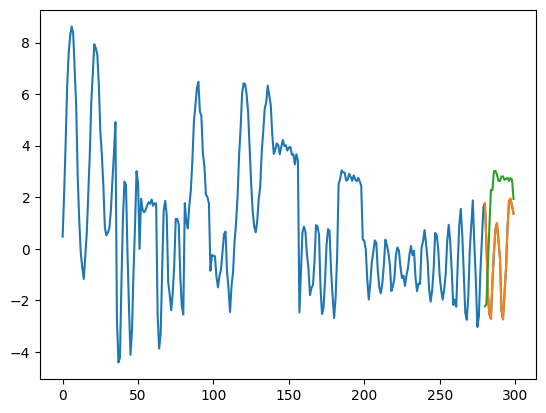

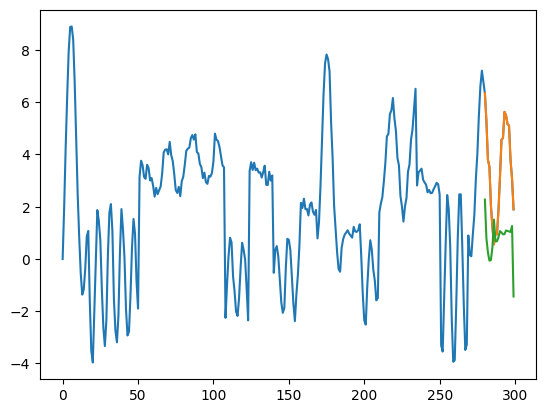

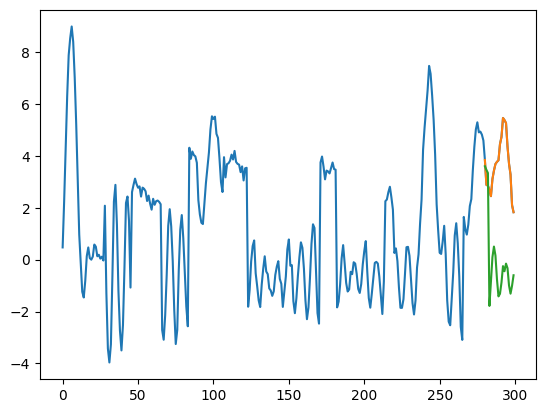

In [451]:
for i in range(3):
    plt.plot(trajs[i], label=f"Mode {i}")
    plt.plot(list(range(280,300)), ground_truth[i], label="Ground Truth")
    plt.plot(list(range(280,300)), all_mean[i], label="Mean")
    plt.show()

In [453]:
np.savez("./results/3_mode_system_autoregressive.npz", ground_truth=ground_truth, mean=all_mean, all_trajs=trajs, lb=all_lb, ub=all_ub)


In [556]:
def inference_3mode(ckpt_file):

    ckpt = torch.load(ckpt_file, map_location="cpu")

    config = ckpt["config"]
    model = build_model(config=config)
    model.load_state_dict(ckpt["model"])

    test_dataset = get_test_dataset(config)
    print("test dataset", test_dataset)
    #test_dataset = datasets.BouncingBallDataset(path=dataset_path)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20)

    #do predictions autoregressively. 
    context_length = config['context_length']
    prediction_length = config['prediction_length']
    print("prediction length", prediction_length)
    ground_truth = []
    all_mean = []
    all_lb = []
    all_ub = []
    all_z_probs = []
    # calculate coverage and width of prediction intervals
    for test_batch, test_label in tqdm(test_loader):
        #true = test_batch[:, -prediction_length:]
        autoregressive_lb = []
        autoregressive_ub = []
        autoregressive_mean = []
        autoregressive_z_probs = []
        for t in range((test_batch.shape[1]-context_length)//prediction_length):
            shift = t*prediction_length
            pred = model.predict(test_batch[:,shift:shift+context_length], num_samples=100)
            pred_y = pred['rec_n_forecast']
            z_probs = pred['z_emp_probs']
            if t == 0:
                offset = 0
            else:
                offset = -prediction_length
            print(t, pred_y.shape, (pred_y[...,offset:]).shape)
            autoregressive_lb.append(np.quantile(pred_y[...,offset:,:], 0.1, axis=0))
            autoregressive_ub.append(np.quantile(pred_y[...,offset:,:], 0.9, axis=0))
            autoregressive_mean.append(np.quantile(pred_y[...,offset:,:], 0.5, axis=0))
            autoregressive_z_probs.append(z_probs[...,offset:])
        all_mean.append(np.concatenate(autoregressive_mean, 1))
        all_lb.append(np.concatenate(autoregressive_lb, 1))
        all_ub.append(np.concatenate(autoregressive_ub, 1))
        all_z_probs.append(np.concatenate(autoregressive_z_probs, 0))
        ground_truth.append(test_batch)
        break
        
    ground_truth = np.concatenate(ground_truth, 0)
    all_mean = np.concatenate(all_mean, 0)
    all_lb = np.concatenate(all_lb, 0)
    all_ub = np.concatenate(all_ub, 0)
    all_z_probs = np.concatenate(all_z_probs, 0)
    return ground_truth, all_mean, all_lb, all_ub, all_z_probs

def inference(ckpt_file):

    ckpt = torch.load(ckpt_file, map_location="cpu")

    config = ckpt["config"]
    model = build_model(config=config)
    model.load_state_dict(ckpt["model"])

    test_dataset = get_test_dataset(config)
    print("test dataset", test_dataset)
    #test_dataset = datasets.BouncingBallDataset(path=dataset_path)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20)

    #do predictions autoregressively. 
    context_length = config['context_length']
    prediction_length = config['prediction_length']
    print("prediction length", prediction_length)
    ground_truth = []
    all_mean = []
    all_lb = []
    all_ub = []
    # calculate coverage and width of prediction intervals
    for test_batch, test_label in tqdm(test_loader):
        #true = test_batch[:, -prediction_length:]
        pred = model.predict(test_batch[:,:context_length], num_samples=100)
        pred_y = pred['rec_n_forecast']
        all_mean.append(np.quantile(pred_y, 0.5, axis=0))
        all_lb.append(np.quantile(pred_y, 0.1, axis=0))
        all_ub.append(np.quantile(pred_y, 0.9, axis=0))
        ground_truth.append(test_batch)
        
    ground_truth = np.concatenate(ground_truth, 0)
    all_mean = np.concatenate(all_mean, 0)
    all_lb = np.concatenate(all_lb, 0)
    all_ub = np.concatenate(all_ub, 0)
    return ground_truth, all_mean, all_lb, all_ub

In [533]:
pred = inference(ckpt_file)

test dataset <src.datasets.ThreeModeSystemDataset object at 0x7fd8e01a8150>
prediction length 20


  0%|          | 0/25 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
  0%|          | 0/25 [00:01<?, ?it/s]


In [534]:
pred.keys()

dict_keys(['rec_n_forecast', 'z_emp_probs'])

In [528]:
ground_truth, all_mean, all_lb, all_ub =inference(ckpt_file)

test dataset <src.datasets.ThreeModeSystemDataset object at 0x7fd9328e06d0>
prediction length 20


  0%|          | 0/25 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


In [555]:
ground_truth, all_mean, all_lb, all_ub, all_z_probs = inference_3mode(ckpt_file)

test dataset <src.datasets.ThreeModeSystemDataset object at 0x7fd8d0adee50>
prediction length 20


  0%|          | 0/25 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim


0 torch.Size([100, 20, 200, 1]) torch.Size([100, 20, 200, 1])
1 torch.Size([100, 20, 200, 1]) torch.Size([100, 20, 200, 1])
2 torch.Size([100, 20, 200, 1]) torch.Size([100, 20, 200, 1])
3 torch.Size([100, 20, 200, 1]) torch.Size([100, 20, 200, 1])
4 torch.Size([100, 20, 200, 1]) torch.Size([100, 20, 200, 1])


  0%|          | 0/25 [00:10<?, ?it/s]

5 torch.Size([100, 20, 200, 1]) torch.Size([100, 20, 200, 1])


In [550]:
ground_truth.shape

(20, 300, 1)

In [553]:
all_mean.shape

(20, 1200, 1)

In [538]:

# coverage
coverage = np.mean(np.logical_and(ground_truth[:,180:200,:] >= all_lb[:,180:200,:], ground_truth[:,180:200,:] <= all_ub[:,180:200,:]))
# width
width = np.mean(all_ub - all_lb)


coverage, width

ValueError: operands could not be broadcast together with shapes (20,20,1) (120,20,1) 

In [519]:
np.std(all_ub - all_lb)


1.5758337649980463

In [ ]:
ckpt_bb = "./Checkpoints/bouncing_ball.pt"
ckpt_bbnoisy = "./Checkpoints/bb_noisy.pt"

In [ ]:
ground_truth, all_mean, all_lb, all_ub = autoregressive_pred(ckpt_bb)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 50/50 [01:09<00:00,  1.40s/it]


In [510]:
all_mean.shape

(20, 200, 1)

In [511]:
ground_truth.shape

(20, 300, 1)

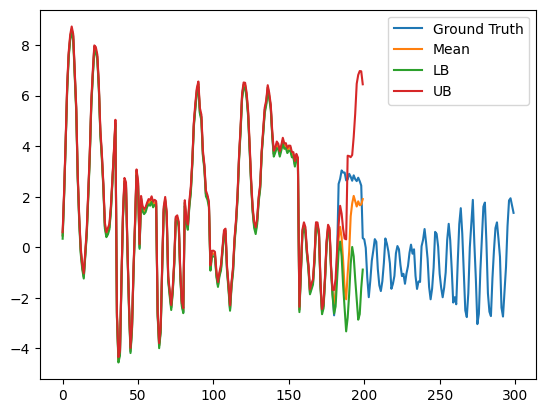

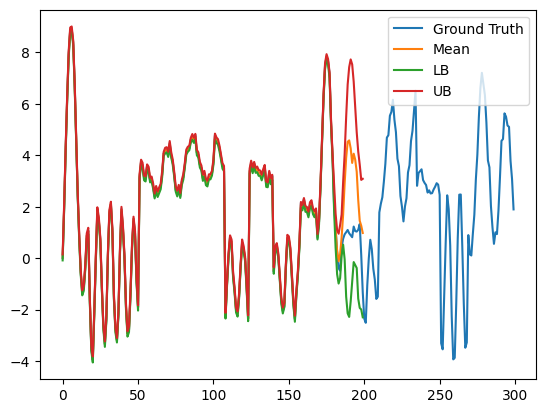

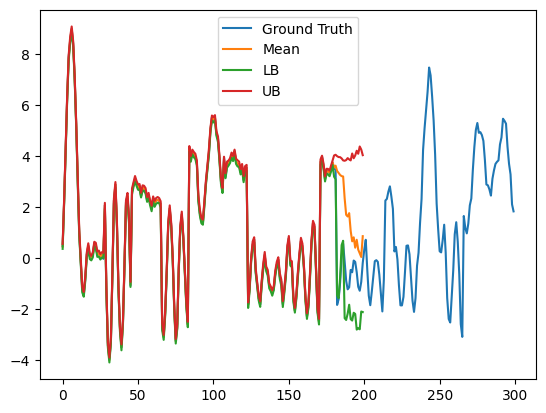

In [513]:
for i in range(3):
    plt.plot( ground_truth[i].squeeze(), label="Ground Truth")
    plt.plot(all_mean[i].squeeze(), label="Mean")
    plt.plot(all_lb[i].squeeze(), label="LB")
    plt.plot(all_ub[i].squeeze(), label="UB")
    plt.legend()
    plt.show()

In [469]:
ckpt_file = ckpt_3m
ckpt = torch.load(ckpt_file, map_location="cpu")

config = ckpt["config"]
model = build_model(config=config)
model.load_state_dict(ckpt["model"])

test_dataset = get_test_dataset(config)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80)
extra_args = dict()
extra_args = {"dur_temperature": 1.0}
device = 'cpu'

In [474]:
for a,b in test_loader:
    print(a.shape)
    break

torch.Size([80, 300, 1])


## Noisy

In [57]:
ground_truth, all_mean, all_lb, all_ub = autoregressive_pred(ckpt_bbnoisy)

#save ground truth, all_mean, all_lb, all_ub
np.savez("./results/bouncing_ball_noisy_autoregressive.npz", ground_truth=ground_truth, mean=all_mean, lb=all_lb, ub=all_ub)


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


In [58]:

# coverage
coverage = np.mean(np.logical_and(ground_truth >= all_lb, ground_truth <= all_ub))
# width
width = np.mean(all_ub - all_lb)


coverage, width

(0.78504, 0.46371949870007767)

# Electricity

In [414]:
dataset = datasets.GTSUnivariateDataset("electricity_nips", batch_size=50, mode="test")
test_dataset = dataset.gluonts_dataset

ckpt_file = "Checkpoints/electricity_nips.pt"
try:
    ckpt = torch.load(ckpt_file, map_location="cpu")
except FileNotFoundError:
    print(f"Can't find {ckpt_file}!")

config = ckpt["config"]
device = 'cpu'
model = build_model(config=config)
model.load_state_dict(ckpt["model"])
model = model.to(device)

In [415]:
from src.datasets import create_input_transform
from gluonts.dataset.loader import InferenceDataLoader
from gluonts.torch.batchify import batchify
import pandas as pd

from gluonts.transform import TransformedDataset
from gluonts.transform import AdhocTransform


batch_size = 10
assert dataset.metadata["context_length"] == model.context_length
assert dataset.metadata["prediction_length"] == model.prediction_length
prediction_length = dataset.metadata["prediction_length"]
context_length = dataset.metadata["context_length"]

freq = dataset.freq
max_len = 1000

def add_ts_dataframe(data_iterator):
    for data_entry in data_iterator:
        data = data_entry.copy()
        index = pd.date_range(
            start=data["start"],
            freq=freq,
            periods=data["target"].shape[-1],
        )
        data["ts"] = pd.DataFrame(index=index, data=data["target"].transpose())
        yield data

def test_generator(dataset):
    size = 0
    for data_entry in add_ts_dataframe(iter(dataset)):
        if size < max_len:
            yield data_entry["ts"]
            size += 1
        else:
            break

def truncate_target(data):
    data = data.copy()
    target = data["target"]
    assert (
        target.shape[-1] >= prediction_length
    )  # handles multivariate case (target_dim, history_length)
    data["target"] = target[..., :-prediction_length]
    return data

trucated_dataset = TransformedDataset(
    test_dataset, transformation=AdhocTransform(truncate_target)
)

input_transform = create_input_transform(
    is_train=False,
    prediction_length=prediction_length,
    past_length=context_length,
    use_feat_static_cat=True,
    use_feat_dynamic_real=False,
    freq=freq,
    time_features=None,
)
inference_loader = InferenceDataLoader(
    dataset=trucated_dataset,
    transform=input_transform,
    batch_size=batch_size,
    stack_fn=batchify,
    #num_workers=1,
)

In [410]:
from gluonts.model.forecast import SampleForecast

def prediction_generator(inference_loader, num_samples=100, max_len = 100):
    size = 0
    for batch in inference_loader:
        ys = batch["past_target"]
        forecast_starts = batch["forecast_start"]
        item_ids = (
            batch["item_id"]
            if "item_id" in batch
            else [int(x[0]) for x in batch["feat_static_cat"]]
        )
        assert ys.shape[-2] == context_length
        prediction =  model.predict(
                ys.to(device),
                ctrl_inputs=dict(
                    feat_static_cat=batch["feat_static_cat"].long().to(device),
                    past_time_feat=batch["past_time_feat"].to(device),
                    future_time_feat=batch["future_time_feat"].to(device),
                ),
                num_samples=num_samples,
            )
        rec_n_forecast = (prediction
           ["rec_n_forecast"]
            .data.cpu()
            .numpy()
        )
        z_probs = prediction["z_emp_probs"].data.cpu().numpy()

        assert rec_n_forecast.shape[-2] == prediction_length + context_length, (
            f"Length of rec + forecast {rec_n_forecast.shape[-2]}"
            f" along time dimension should be "
            f"context_length {context_length} "
            f"+ prediction_length {prediction_length}"
        )
        # get rid of the truncation
        forecasts = rec_n_forecast[..., -prediction_length:, :]
        all_preds = rec_n_forecast

        forecasts = np.swapaxes(forecasts, 0, 1)
        all_preds = np.swapaxes(all_preds, 0, 1)

        if forecasts.shape[-1] == 1:
            all_preds = all_preds.squeeze(-1)
            forecasts = forecasts.squeeze(-1)

        for forecast_start, item_id, forecast, everything in zip(
            forecast_starts, item_ids, forecasts, all_preds
        ):
            if size < max_len:
                sf = SampleForecast(
                    samples = forecast,
                    start_date=forecast_start,
                    freq=freq,
                    item_id=item_id,
                )
                yield sf, everything, z_probs
                size += 1
            else:
                break
        if size == max_len:
            break



In [416]:
max_len = 200

pred_gen = prediction_generator(inference_loader, max_len=max_len)
test_gen = test_generator(test_dataset)

ts_iterator = iter(test_gen)
fcst_iterator = iter(pred_gen)
ground_truth, all_mean, all_lb, all_ub, all_z_probs = [], [], [], [], []
prev_preds = []
size = 0

with tqdm(
    zip(ts_iterator, fcst_iterator),
    total=max_len,
    desc="Running evaluation",
) as it, np.errstate(invalid="ignore"): 
    
    for ts, (forecast, everything, z_probs) in it:
        #print(forecast.samples.shape)
        rec_n_forecast = forecast.samples[..., -prediction_length:]
        target = np.atleast_1d(
            np.squeeze(ts.loc[forecast.index].transpose())
        )

        mean = get_quantile_forecast(rec_n_forecast, 0.5)#axis=1)
        lb = get_quantile_forecast(rec_n_forecast, 0.1)#axis=1)
        ub = get_quantile_forecast(rec_n_forecast, 0.9)#axis=1) 

        prev_mean = get_quantile_forecast(everything[..., :-prediction_length], 0.5)

        all_lb.append(lb)
        all_ub.append(ub)
        all_mean.append(mean)
        ground_truth.append(target)
        prev_preds.append(prev_mean)
        all_z_probs.append(z_probs)



Running evaluation:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
Running evaluation: 100%|██████████| 200/200 [00:58<00:00,  3.39it/s]


In [417]:
ground_truth = np.array(ground_truth)
all_mean = np.array(all_mean)
all_lb = np.array(all_lb)
all_ub = np.array(all_ub)
prev_preds = np.array(prev_preds)
all_z_probs = np.array(all_z_probs)


In [418]:
def Xs(inference_loader,  max_len = max_len):
    size = 0
    xs = []
    for batch in inference_loader:
        x = batch["past_target"]
        xs.append(x)
        size += x.shape[0]
        if size == max_len:
            break
    return np.concatenate(xs, 0)

In [419]:
input_data = Xs(inference_loader)

/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


In [420]:
np.savez("./results/electricity_nips_test.npz", input_data=input_data, ground_truth=ground_truth, all_mean=all_mean, all_lb=all_lb, all_ub=all_ub, prev_preds=prev_preds, all_z_probs=all_z_probs)

In [379]:
ground_truth.shape

(20, 168)

In [394]:
np.mean(np.clip(all_mean - all_lb, 0, 500))

50.29240630777296

In [395]:

# coverage
cov = np.logical_and(ground_truth >= all_lb, ground_truth <= all_ub)
coverage = np.mean(cov)
cov_std = np.std(np.mean(cov, axis=1))
# width
widths = np.clip(all_ub - all_lb, 0, 500)
width = np.mean(widths)
width_std = np.std(np.mean(widths, axis=1))



In [396]:
coverage, cov_std, width, width_std

(0.7523214285714286,
 0.14587316025650487,
 87.21955631245908,
 119.83863439591792)

# Putting things together

In [421]:
dataset = datasets.GTSUnivariateDataset("traffic_nips", batch_size=50, mode="test")
test_dataset = dataset.gluonts_dataset

ckpt_file = "Checkpoints/traffic_nips.pt"
try:
    ckpt = torch.load(ckpt_file, map_location="cpu")
except FileNotFoundError:
    print(f"Can't find {ckpt_file}!")

config = ckpt["config"]
device = 'cpu'
model = build_model(config=config)
model.load_state_dict(ckpt["model"])
model = model.to(device)

In [422]:
from src.datasets import create_input_transform
from gluonts.dataset.loader import InferenceDataLoader
from gluonts.torch.batchify import batchify
import pandas as pd

from gluonts.transform import TransformedDataset
from gluonts.transform import AdhocTransform


batch_size = 10
assert dataset.metadata["context_length"] == model.context_length
assert dataset.metadata["prediction_length"] == model.prediction_length
prediction_length = dataset.metadata["prediction_length"]
context_length = dataset.metadata["context_length"]

freq = dataset.freq

trucated_dataset = TransformedDataset(
    test_dataset, transformation=AdhocTransform(truncate_target)
)

input_transform = create_input_transform(
    is_train=False,
    prediction_length=prediction_length,
    past_length=context_length,
    use_feat_static_cat=True,
    use_feat_dynamic_real=False,
    freq=freq,
    time_features=None,
)
inference_loader = InferenceDataLoader(
    dataset=trucated_dataset,
    transform=input_transform,
    batch_size=batch_size,
    stack_fn=batchify,
    #num_workers=1,
)

In [423]:
context_length, prediction_length

(336, 168)

In [424]:
max_len = 200

pred_gen = prediction_generator(inference_loader, max_len=max_len)
test_gen = test_generator(test_dataset)

ts_iterator = iter(test_gen)
fcst_iterator = iter(pred_gen)
ground_truth, all_mean, all_lb, all_ub, all_z_probs = [], [], [], [], []
prev_preds = []
size = 0

with tqdm(
    zip(ts_iterator, fcst_iterator),
    total=max_len,
    desc="Running evaluation",
) as it, np.errstate(invalid="ignore"): 
    
    for ts, (forecast, everything, z_probs) in it:
        #print(forecast.samples.shape)
        rec_n_forecast = forecast.samples[..., -prediction_length:]
        target = np.atleast_1d(
            np.squeeze(ts.loc[forecast.index].transpose())
        )

        mean = get_quantile_forecast(rec_n_forecast, 0.5)#axis=1)
        lb = get_quantile_forecast(rec_n_forecast, 0.1)#axis=1)
        ub = get_quantile_forecast(rec_n_forecast, 0.9)#axis=1) 

        prev_mean = get_quantile_forecast(everything[..., :-prediction_length], 0.5)

        all_lb.append(lb)
        all_ub.append(ub)
        all_mean.append(mean)
        ground_truth.append(target)
        prev_preds.append(prev_mean)
        all_z_probs.append(z_probs)



Running evaluation:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
/Users/sophiasun/Desktop/2cool4school/phd/switching/REDSDS/src/torch_utils.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices = indices // dim
Running evaluation: 100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


In [425]:
ground_truth = np.array(ground_truth)
all_mean = np.array(all_mean)
all_lb = np.array(all_lb)
all_ub = np.array(all_ub)
prev_preds = np.array(prev_preds)
all_z_probs = np.array(all_z_probs)


In [426]:
def Xs(inference_loader,  max_len = max_len):
    size = 0
    xs = []
    for batch in inference_loader:
        x = batch["past_target"]
        xs.append(x)
        size += x.shape[0]
        if size == max_len:
            break
    return np.concatenate(xs, 0)

In [427]:
input_data = Xs(inference_loader)

In [428]:
np.savez("./results/traffic_nips_test.npz", input_data=input_data, ground_truth=ground_truth, all_mean=all_mean, all_lb=all_lb, all_ub=all_ub, prev_preds=prev_preds, all_z_probs=all_z_probs)

In [429]:

# coverage
cov = np.logical_and(ground_truth >= all_lb, ground_truth <= all_ub)
coverage = np.mean(cov)
cov_std = np.std(np.mean(cov, axis=1))
# width
widths = np.clip(all_ub - all_lb, 0, 500)
width = np.mean(widths)
width_std = np.std(np.mean(widths, axis=1))



In [430]:
coverage, cov_std, width, width_std

(0.8655357142857143,
 0.11201424165911726,
 0.02808489076668187,
 0.015446955367073143)

In [408]:
coverage, cov_std, width, width_std

(0.8648809523809524,
 0.11556360216402359,
 0.028024603526274283,
 0.01517696269793084)

## Archive

In [25]:

true_tss = np.concatenate(true_tss, 0)
recons_tss = np.concatenate(recons_tss, 0)
true_segs = np.concatenate(true_segs, 0)
pred_segs = np.concatenate(pred_segs, 0)
seg_metrics = evaluation.evaluate_segmentation(
    true_segs, pred_segs, K=config["num_categories"]
)
#print(config["dataset"], seg_metrics)


In [26]:
seg_metrics

{'nmi_score': 0.765731146550337,
 'ari_score': 0.8514450465440498,
 'accuracy': 0.961375,
 'f1_score': 0.9614082389518032}

In [30]:
evaluation.evaluate_segmentation(
    true_segs[0], pred_segs[0], K=config["num_categories"]
)

{'nmi_score': 1.0, 'ari_score': 1.0, 'accuracy': 1.0, 'f1_score': 1.0}

In [ ]:

pred_segs = []
true_segs = []
for test_batch, test_label in tqdm(test_loader):
    test_batch = test_batch.to(device)
    pred = model.predict(test_batch, num_samples=100)
    true = test_batch[:, config['context_length']:]
    pred_segs.append(torch2numpy(torch.argmax(pred['z_emp_probs'], dim=-1)))
    true_segs.append(torch2numpy(test_label[:, config['context_length']:]))


In [106]:
seg_error = evaluation.evaluate_segmentation(np.concatenate(true_segs, 0), np.concatenate(pred_segs, 0), K=config["num_categories"])

seg_error

{'nmi_score': 0.10380844559277072,
 'ari_score': 0.140397887557092,
 'accuracy': 0.68736,
 'f1_score': 0.6873676161666078}

In [84]:
np.mean(mses)

0.08520873

In [97]:
pred_segs

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])